In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

import os
import time
from IPython.core.display import clear_output
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import lmfit
import functools
import imageio.v3 as imageio
import cv2


/tmp/ipykernel_611035/3139042232.py:9: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


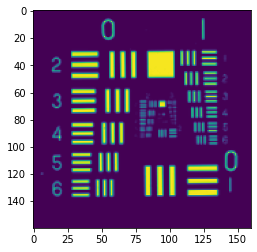

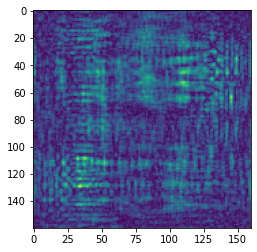

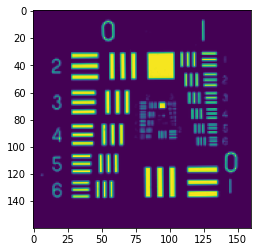

In [3]:
dim = (160, 160)
cm = 1e-2
mm = 1e-3
um = 1e-6
nm = 1e-9

x = np.linspace(-50, 50, dim[0]) * um
y = np.linspace(-50, 50, dim[0]) * um
X, Y = np.meshgrid(x, y) 
z = 3 * cm # distance from the meta to camera
d = 10 * um # meta aperture
lam = 660 * nm # wavelength
k = 2 * np.pi / lam # wave number

# setup fourier space
kx = np.fft.fftfreq(len(x), np.diff(x)[0]) * 2 * np.pi
ky = np.fft.fftfreq(len(y), np.diff(y)[0]) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky)

# verify that the dimension is correct
assert k**2 - max(kx)**2 - max(ky)**2 > 0, "Simulation dimension is too high"

A = np.zeros(dim)
A[(abs(X) < d/2) & (abs(Y) < d/2)] = 1

target = imageio.imread('../common/RC_200.png')
# change to gray scale
target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
A = cv2.resize(target, dim, interpolation=cv2.INTER_AREA)

plt.imshow(A)
plt.show()

Ak = np.fft.fft2(A) # kernel

H = np.exp(1j * z * np.sqrt(k**2 - np.abs(KX)**2 - np.abs(KY)**2))
E = np.fft.ifft2(Ak * H)

plt.imshow(np.abs(E))
plt.show()

E = np.roll(E, 1, axis=0)

iH = np.exp(1j * -z * np.sqrt(k**2 - np.abs(KX)**2 - np.abs(KY)**2))
iAk = np.fft.fft2(E) # kernel
iA = np.fft.ifft2(iAk * iH)

plt.imshow(np.abs(iA))
plt.show()


Plotting target image


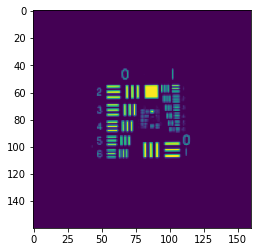

Plottiing intensity on z=30.0mm


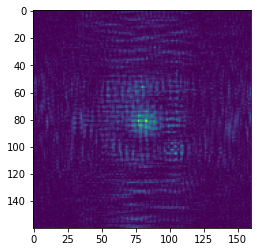

Plotting cropped image


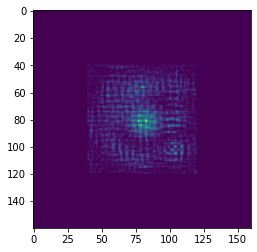

Plotting reconstructed image


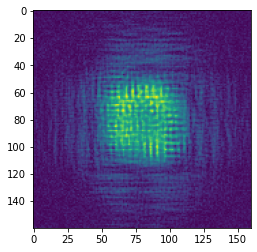

In [46]:
from numpy import real

dim = (160, 160)
cm = 1e-2
mm = 1e-3
um = 1e-6
nm = 1e-9

x = np.linspace(-50, 50, dim[0]) * um
y = np.linspace(-50, 50, dim[0]) * um
X, Y = np.meshgrid(x, y) 
z = 3 * cm # distance from the meta to camera
lam = 660 * nm # wavelength
k = 2 * np.pi / lam # wave number

# setup fourier space
kx = np.fft.fftfreq(len(x), np.diff(x)[0]) * 2 * np.pi
ky = np.fft.fftfreq(len(y), np.diff(y)[0]) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky)

# verify that the dimension is correct
assert k**2 - max(kx)**2 - max(ky)**2 > 0, "Simulation dimension is too high"

A = np.zeros(dim)

target = imageio.imread('../common/RC_200.png')
# change to gray scale
target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
ratio = 0.5
T = cv2.resize(target, (int(dim[0]*ratio), int(dim[1]*ratio)), interpolation=cv2.INTER_AREA)

d0 = int(dim[0]*0.5*(1-ratio))
d1 = int(dim[1]*0.5*(1-ratio))
A[d0:d0+T.shape[0], d1:d1+T.shape[1]] = T

print('Plotting target image')
plt.imshow(A)
plt.show()

Ak = np.fft.fft2(A) # kernel

H = np.exp(1j * z * np.sqrt(k**2 - np.abs(KX)**2 - np.abs(KY)**2))
E = np.fft.ifft2(Ak * H)

I = np.abs(E)**2 # intensity
print(f'Plottiing intensity on z={z/mm}mm')
plt.imshow(I)
plt.show()

E = np.roll(E, 1, axis=0)

iratio = 0.5
id0 = int(dim[0]*0.5*(1-iratio))
id1 = int(dim[1]*0.5*(1-iratio))

iE = np.zeros(dim)
iT = np.sqrt(I)[id0:id0+int(dim[0]*iratio), id1:id1+int(dim[0]*iratio)]
iE[id0:id0+iT.shape[0], id1:id1+iT.shape[1]] = iT

print('Plotting cropped image')
plt.imshow(np.abs(iE)**2)
plt.show()

iH = np.exp(1j * -z * np.sqrt(k**2 - np.abs(KX)**2 - np.abs(KY)**2))
iAk = np.fft.fft2(iE) # kernel
iA = np.fft.ifft2(iAk * iH)

print('Plotting reconstructed image')
plt.imshow(np.abs(iA))
plt.show()


## Conclusion: 
1. camera only capture the intensity profile, but not the phase profile. It is impossible to reconstruct the target image without the phase information. 

2. fourier space on the simulation is wrapped, therefore we need to make the target smaller and add padding to simulate the actual experiment.

In [1]:
# trying GS algorithm

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

import os
import time
from IPython.core.display import clear_output
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import lmfit
import functools
import imageio.v3 as imageio
import cv2


/tmp/ipykernel_193377/238330480.py:11: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


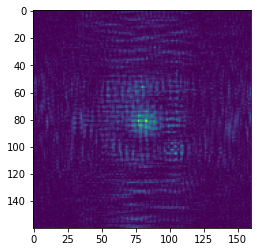

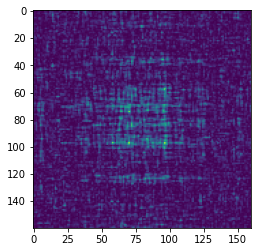

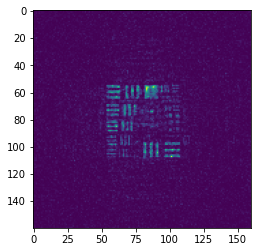

In [50]:
dim = (160, 160)
m = 1
cm = 1e-2
mm = 1e-3
um = 1e-6
nm = 1e-9


x = np.linspace(-50, 50, dim[0]) * um
y = np.linspace(-50, 50, dim[0]) * um
X, Y = np.meshgrid(x, y) 
z = 3 * cm # distance from the meta to camera
lam = 660 * nm # wavelength
k = 2 * np.pi / lam # wave number

# setup fourier space
kx = np.fft.fftfreq(len(x), np.diff(x)[0]) * 2 * np.pi
ky = np.fft.fftfreq(len(y), np.diff(y)[0]) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky)

# verify that the dimension is correct
assert k**2 - max(kx)**2 - max(ky)**2 > 0, "Simulation dimension is too high"

target = imageio.imread('../common/RC_200.png')
ratio = 0.5

def load(target, ratio):
    A = np.zeros(dim)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    T = cv2.resize(target, (int(dim[0]*ratio), int(dim[1]*ratio)), interpolation=cv2.INTER_AREA)
    d0 = int(dim[0]*0.5*(1-ratio))
    d1 = int(dim[1]*0.5*(1-ratio))
    A[d0:d0+T.shape[0], d1:d1+T.shape[1]] = T
    return A

def forward_propagate(A, z):
    Ak = np.fft.fft2(A) # kernel
    H = np.exp(1j * z * np.sqrt(k**2 - np.abs(KX)**2 - np.abs(KY)**2))
    E = np.fft.ifft2(Ak * H)
    return E

def get_intensity(A):
    return np.abs(A)**2

def get_phase(A):
    return np.angle(A)

def plot(mat):
    plt.imshow(mat)
    plt.show()

def gerchberg_saxton(source, target, delta):
    phase = np.random.rand(dim[0], dim[1]) * 2 * pi
    A = source
    for i in range(2000):
        B = np.abs(source) * np.exp(1j * get_phase(A))
        C = forward_propagate(B, delta)
        D = np.abs(target) * np.exp(1j * get_phase(C))
        A = forward_propagate(D, -delta)
    return get_phase(A)

A = load(target, ratio)
delta = 0.1*z
I1 = get_intensity(forward_propagate(A, z))
I2 = get_intensity(forward_propagate(A, z+delta))

plot(I1)
plot(I2)

phase1 = gerchberg_saxton(I1, I2, delta)
retrieved_A = forward_propagate(I1 * np.exp(1j * phase1), -z)

plot(get_intensity(retrieved_A))